In [2]:
r"""
Use the prepared cutout of ERA5 model level data to prepare capacity factors for AWE, both onshore and
offshore.

For floating offshore?
"""
import atlite
import functools
import numpy as np
import geopandas as gpd
import pandas as pd
import xarray as xr

In [3]:
boundaries = "../build/shapes/eez.geojson"
natura2000 = "../data/potentials_offshore/natura2000_areas/eea_v_3035_100_k_natura2000_p_2021_v12_r01/SHP/Natura2000_end2021_rev1_epsg3035.shp"
shipdensity = "../data/potentials_offshore/shipping_density_global/shipdensity_global.tif"
gebco = "../data/potentials_offshore/gebco_2023_sub_ice_topo/GEBCO_2023_sub_ice_topo.nc"

df_boundaries = gpd.read_file(boundaries)
cutout = atlite.Cutout("../build/cutouts/cutout-era5-model-level_adapted.nc")

In [5]:
# Load all exclusion shapes to generate potentials
# TODO: which crs?
# TODO: res determined by coarsest dataset?
excluder = atlite.ExclusionContainer()

excluder.add_geometry(natura2000)  # which crs?

max_depth = 60
func = functools.partial(np.greater, -max_depth)
excluder.add_raster(gebco, crs=4326, codes=func)  # which crs?

# TODO: Can I save data to plot potentials as shapefile? Or is it only available as raster data?
# masked, transform = excluder.compute_shape_availability(df_boundaries)

In [27]:
bh = df_boundaries.iloc[[1]]

In [28]:
availability = cutout.availabilitymatrix(bh, excluder)

Compute availability matrix:   0%|          | 0/1 [00:00<?, ? gridcells/s]

Compute availability matrix: 100%|██████████| 1/1 [01:52<00:00, 112.46s/ gridcells]


In [29]:
availability

<xarray.DataArray (dim_0: 1, y: 161, x: 217)>
array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]])
Coordinates:
  * dim_0    (dim_0) int64 1
  * y        (y) float64 72.0 71.75 71.5 71.25 71.0 ... 32.75 32.5 32.25 32.0
  * x        (x) float64 -17.0 -16.75 -16.5 -16.25 ... 36.25 36.5 36.75 37.0

<Axes: title={'center': 'dim_0 = 6'}, xlabel='x', ylabel='y'>

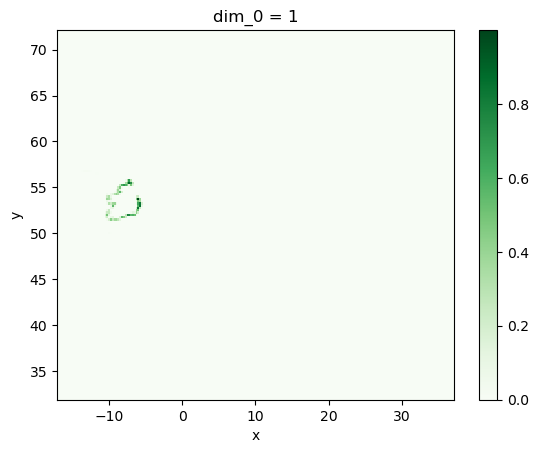

In [32]:
import matplotlib.pyplot as plt
availability.sel(dim_0=1).plot(cmap="Greens")
bh.plot(ax=ax, edgecolor="k", color="None")
cutout.grid.plot(ax=ax, color="None", edgecolor="grey", ls=":")

In [49]:
# prepare power curve
awe_500kw_sw = pd.read_csv("../data/power_curves/AWE_500kw_softwing.csv", index_col=0)
awe_500kw_sw = dict(V=np.array(list(awe_500kw_sw.index)), POW=np.array(list(awe_500kw_sw["power"])), hub_height=100)
awe_500kw_sw["P"] = np.max(awe_500kw_sw["POW"])

In [ ]:
from operator import itemgetter

def convert_wind_awe(ds, turbine):
    """
    Convert wind speeds for turbine to wind energy generation.
    """
    V, POW, hub_height, P = itemgetter("V", "POW", "hub_height", "P")(turbine)

    #wnd_hub = windm.extrapolate_wind_speed(ds, to_height=hub_height)
    wnd_hub = ds.u

    def _interpolate(da):
        return np.interp(da, V, POW / P)

    da = xr.apply_ufunc(
        _interpolate,
        wnd_hub,
        input_core_dims=[[]],
        output_core_dims=[[]],
        output_dtypes=[wnd_hub.dtype],
        dask="parallelized",
    )

    da.attrs["units"] = "MWh/MWp"
    da = da.rename("specific generation")

    return da

capfac_wind_awe = cutout.convert_and_aggregate(convert_func=convert_wind_awe, turbine=awe_500kw_sw, shapes=df_boundaries)


In [1]:

capfac_wind_awe.to_netcdf("../build/capacity_factors/capacity_factors_awe.nc")

NameError: name 'capfac_wind_awe' is not defined